In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
data = pd.read_csv('2019WinterDataScienceInternChallengeDataSet-Sheet1.csv')

In [3]:
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


In [4]:
order_amount_sum = data['order_amount'].sum()
total_items_sum = data['total_items'].sum()

In [5]:
print(order_amount_sum), print(total_items_sum)

15725640
43936


(None, None)

In [6]:
#actual Average Order Value (AOV)
AOV = order_amount_sum / total_items_sum
print(round(AOV,2))

357.92


In [7]:
#incorrect AOV calculation
order_amount_sum_incorrect = data['order_amount'].sum()
total_items_sum_incorrect = data['total_items'].count() #count was the mistake
AOV = order_amount_sum_incorrect / total_items_sum_incorrect
print(round(AOV,2))

3145.13


In [8]:
#Data Analysis using K-Means Clustering 

In [9]:
#Data Scleaning
print(data.info())
print(data.dropna())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   order_id        5000 non-null   int64 
 1   shop_id         5000 non-null   int64 
 2   user_id         5000 non-null   int64 
 3   order_amount    5000 non-null   int64 
 4   total_items     5000 non-null   int64 
 5   payment_method  5000 non-null   object
 6   created_at      5000 non-null   object
dtypes: int64(5), object(2)
memory usage: 273.6+ KB
None
      order_id  shop_id  user_id  order_amount  total_items payment_method  \
0            1       53      746           224            2           cash   
1            2       92      925            90            1           cash   
2            3       44      861           144            1           cash   
3            4       18      935           156            1    credit_card   
4            5       18      883           156     

In [10]:
#Data Pre-processing

In [11]:
data.head()

,order_id,shop_id,user_id,order_amount,total_items,payment_method,created_at
0,1,53,746,224,2,cash,2017-03-13 12:36:56
1,2,92,925,90,1,cash,2017-03-03 17:38:52
2,3,44,861,144,1,cash,2017-03-14 4:23:56
3,4,18,935,156,1,credit_card,2017-03-26 12:43:37
4,5,18,883,156,1,credit_card,2017-03-01 4:35:11


## What is RFM?
### R (Recency): Number of days since last purchase
### F (Frequency): Number of tracsactions
### M (Monetary): Total amount of transactions (revenue contributed)

In [12]:
#Monetary
data['user_id'] = data['user_id'].astype(str)
rfm_ds_m = data.groupby('user_id')['order_amount'].sum()
rfm_ds_m = rfm_ds_m.reset_index()
rfm_ds_m.columns = ['CustomerID', 'Amount']
print(rfm_ds_m)

    CustomerID    Amount
0          607  11968000
1          700      4790
2          701      5162
3          702      5286
4          703      6091
..         ...       ...
296        995      5316
297        996      5312
298        997     29236
299        998      2620
300        999      7195

[301 rows x 2 columns]


In [13]:
#Frequency
rfm_ds_f = data.groupby('user_id')['shop_id'].count()
rfm_ds_f = rfm_ds_f.reset_index()
rfm_ds_f.columns = ['CustomerID', 'Frequency']
print(rfm_ds_f)

    CustomerID  Frequency
0          607         17
1          700         16
2          701         13
3          702         13
4          703         16
..         ...        ...
296        995         15
297        996         21
298        997         13
299        998          9
300        999         24

[301 rows x 2 columns]


In [14]:
#Recency
data['created_at'] = pd.to_datetime(data['created_at'],format='%Y-%m-%d %H:%M:%S')
max_date = max(data['created_at'])
data['Diff'] = max_date - data['created_at']
rfm_ds_p = data.groupby('user_id')['Diff'].min()
rfm_ds_p = rfm_ds_p.reset_index()
rfm_ds_p.columns = ['CustomerID','Diff']
rfm_ds_p['Diff'] = rfm_ds_p['Diff'].dt.days
print(rfm_ds_p)

    CustomerID  Diff
0          607     2
1          700     0
2          701     3
3          702     1
4          703     1
..         ...   ...
296        995     2
297        996     1
298        997     4
299        998     2
300        999     2

[301 rows x 2 columns]


In [15]:
#Combining Data
rfm_ds_final = pd.merge(rfm_ds_m,rfm_ds_f,on='CustomerID',how='inner')
rfm_ds_final = pd.merge(rfm_ds_final,rfm_ds_p,on='CustomerID',how='inner')
rfm_ds_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_ds_final.head())

  CustomerID    Amount  Frequency  Recency
0        607  11968000         17        2
1        700      4790         16        0
2        701      5162         13        3
3        702      5286         13        1
4        703      6091         16        1


## What are outliers?
### An outlier is an object that deviates significantly from the rest of the objects. They can be caused by measurement or execution error. The analysis of outlier data is referred to as outlier analysis or outlier mining.

In [16]:
Q1 = rfm_ds_final.Amount.quantile(0.05)
Q3 = rfm_ds_final.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Amount >= Q1 - 1.5*IQR) & (rfm_ds_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Recency.quantile(0.05)
Q3 = rfm_ds_final.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Recency >= Q1 - 1.5*IQR) & (rfm_ds_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_ds_final.Frequency.quantile(0.05)
Q3 = rfm_ds_final.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_ds_final = rfm_ds_final[(rfm_ds_final.Frequency >= Q1 - 1.5*IQR) & (rfm_ds_final.Frequency <= Q3 + 1.5*IQR)]

In [17]:
print(rfm_ds_final.shape)

(299, 4)


In [18]:
#scaling
X = rfm_ds_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_ds_scaled = scaler.fit_transform(X)

In [19]:
rfm_ds_scaled = pd.DataFrame(rfm_ds_scaled)
rfm_ds_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_ds_scaled.head()

,Amount,Frequency,Recency
0,0.025246,0.428571,0.000000
1,0.028748,0.285714,0.250000
2,0.029915,0.285714,0.083333
3,0.037493,0.428571,0.083333
4,0.016435,0.333333,0.083333


In [20]:
#model creation
kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_ds_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[2 2 2 2 2 0 2 1 2 1 2 0 0 0 2 2 2 2 0 2 2 0 2 0 2 0 0 0 2 2 2 0 2 0 0 2 0
 2 0 0 2 2 0 2 2 0 0 2 2 0 2 2 0 2 2 2 1 2 2 0 1 0 0 2 0 2 1 2 0 2 0 2 2 0
 0 1 0 2 0 2 2 2 2 2 0 0 0 1 0 0 0 0 2 0 0 2 2 2 0 0 0 0 2 2 2 2 2 2 0 2 1
 0 2 2 1 0 2 1 1 2 2 2 2 0 0 2 2 2 1 0 2 2 2 2 1 2 0 2 2 0 2 0 0 2 2 0 2 0
 0 0 2 2 0 0 0 1 2 0 0 2 0 2 2 0 0 2 2 2 0 1 2 0 0 2 0 0 0 2 2 2 2 2 0 0 0
 2 2 0 2 0 2 2 2 0 2 2 0 2 2 2 0 2 2 2 2 0 2 2 2 2 2 0 2 0 1 2 0 2 2 0 0 0
 0 2 0 2 1 1 2 0 0 0 0 0 1 1 2 2 2 0 2 0 2 0 2 1 0 2 2 0 2 2 0 0 2 2 2 2 0
 1 2 1 0 2 2 0 1 0 1 0 2 2 2 0 0 2 2 0 0 0 2 0 1 2 0 0 0 2 2 0 2 0 2 0 2 0
 2 2 0]


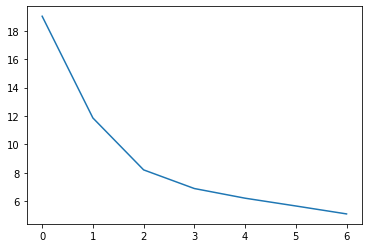

In [21]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

## Silhouette Analysis
### silhouette score=𝑝−𝑞/𝑚𝑎𝑥(𝑝,𝑞)
### 𝑝 is the mean distance to the points in the nearest cluster that the data point is not a part of
### 𝑞 is the mean intra-cluster distance to all the points in its own cluster.
### The value of the silhouette score range lies between -1 to 1.
### A score closer to 1 indicates that the data point is very similar to other data points in the cluster,
### A score closer to -1 indicates that the data point is not similar to the data points in its cluster.


In [22]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_ds_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_ds_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5274513839047942
For n_clusters=3, the silhouette score is 0.3905398245453925
For n_clusters=4, the silhouette score is 0.4346105720331052
For n_clusters=5, the silhouette score is 0.35188772903458615
For n_clusters=6, the silhouette score is 0.35476176157392697
For n_clusters=7, the silhouette score is 0.32519365134499584
For n_clusters=8, the silhouette score is 0.34312690636074245


In [23]:
rfm_ds_final['Cluster_Id'] = lbs
rfm_ds_final.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
1,700,4790,16,0,2
2,701,5162,13,3,2
3,702,5286,13,1,2
4,703,6091,16,1,2
5,704,3854,14,1,2


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

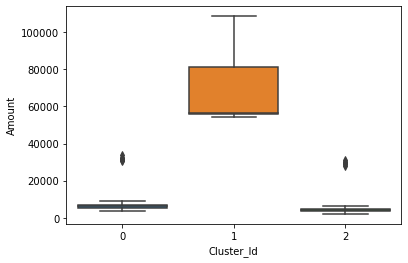

In [24]:
# People falling in cluster 1 are a lot on shopping, whereas cluster 0 and 2 are not spending much
# We can give offer or gift cards to people in cluster 0 and 2
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_ds_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

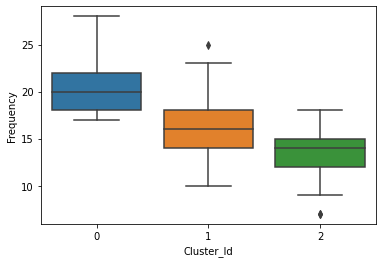

In [25]:
# People in cluster 0 are frquent buyers from a shop
# Shop where people from cluster 2 are visiting must require some special offers or maintenance as the people are less prefering that store
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_ds_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

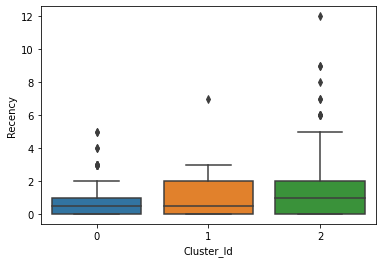

In [26]:
# People of cluster 2 have recenlty purchased
# Provide feedback form, arrange friend referal program for those
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_ds_final)